In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2024-03-01 15:51:57.275184: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 15:51:57.310959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 15:51:57.310978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 15:51:57.311003: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 15:51:57.318295: I tensorflow/core/platform/cpu_feature_g

2.14.0
CPU times: user 2.82 s, sys: 3.42 s, total: 6.24 s
Wall time: 2.2 s


In [2]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/Alibaba-lift.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [56]:
%%time

sample = 0.15
random_state=20220720
df_criteo=df_criteo_ori.sample(frac=sample, random_state=random_state).reset_index(drop=True)



# X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

# X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
# X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
# X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
# X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
# X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
# X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
# X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
# X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
# X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
# X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
# X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
# X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))
# # 
columns = [f'f{i}' for i in range(16)] 
X = df_criteo[columns].values
# 
for i in range(X.shape[1]):
    # 
    X[:, i] = scaling(X[:, i], min=np.min(X[:, i]), max=np.max(X[:, i]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['exposure'].values.reshape(-1, 1)
Y_conv = df_criteo['label'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
X_cali = X_cali[condition_cali]
T_cali = T_cali[condition_cali]
Y_visit_cali = Y_visit_cali[condition_cali]
Y_conv_cali = Y_conv_cali[condition_cali]

condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
X_test = X_test[condition_test]
T_test = T_test[condition_test]
Y_visit_test = Y_visit_test[condition_test]
Y_conv_test = Y_conv_test[condition_test]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

208541 (208541, 16) (74480, 16) 297916 (14895, 16)
208541 (208541, 16) (9005, 16) 297916 (1790, 16)
CPU times: user 331 ms, sys: 251 ms, total: 582 ms
Wall time: 588 ms


# First, on the train set:

### (i) Train DR model

iteration =  1
Epoch 1/1000
2/2 [==============================] - 2s 355ms/step - loss: 40.4640 - obj: 40.4639 - val_loss: 44.9818 - val_obj: 44.9818
Epoch 2/1000
2/2 [==============================] - 0s 107ms/step - loss: 40.2089 - obj: 40.2089 - val_loss: 44.7491 - val_obj: 44.7491
Epoch 3/1000
2/2 [==============================] - 0s 104ms/step - loss: 39.9653 - obj: 39.9653 - val_loss: 44.5242 - val_obj: 44.5242
Epoch 4/1000
2/2 [==============================] - 0s 100ms/step - loss: 39.9742 - obj: 39.9742 - val_loss: 44.3064 - val_obj: 44.3064
Epoch 5/1000
2/2 [==============================] - 0s 100ms/step - loss: 39.9578 - obj: 39.9578 - val_loss: 44.0956 - val_obj: 44.0956
Epoch 6/1000
2/2 [==============================] - 0s 125ms/step - loss: 39.7676 - obj: 39.7676 - val_loss: 43.8952 - val_obj: 43.8952
Epoch 7/1000
2/2 [==============================] - 0s 93ms/step - loss: 39.5847 - obj: 39.5847 - val_loss: 43.6999 - val_obj: 43.6999
Epoch 8/1000
2/2 [================

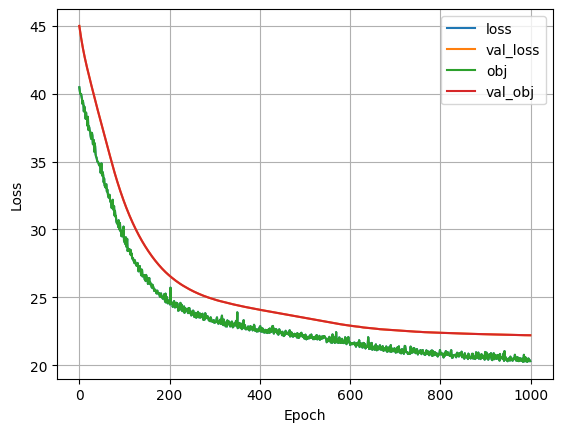

CPU times: user 3min 13s, sys: 50.2 s, total: 4min 4s
Wall time: 2min 10s


In [57]:
%%time
# DR on train set
sys.path.append("..")
from model.uplift_model import *

count = 1
# 2.5e-5
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.roi_model import *

# DIRECT RANK MODEL
# 1e-6
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.roi_model import *

# final_model = get_direct_rank_criteo_model()
# final_model.compile(loss=None, optimizer='adam')
#lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()


for i in range(count):

    print("iteration = ", i + 1)
    
    final_model = get_direct_rank_ali_model()
    final_model.compile(loss=None, optimizer='adam')

    mcp_save = ModelCheckpoint('../model_file/roi/criteo/final_model/direct_rank/a_direct_rank_criteo_model_{}.h5'.format(i+1), save_best_only=False, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train, Y_conv_train, Y_visit_train], validation_split=0.2, epochs=1000, batch_size=100000, shuffle=True, verbose=1, callbacks=[mcp_save, early_stopping])

    
    plot_loss(history, "loss", "val_loss", "obj", "val_obj")

# Second, on the calibration set:

### (i) Infer DR model to obtain $\hat{roi}$.

In [58]:

import sklearn 
import sklearn.metrics
from metric.Metric import *
sys.path.append("..")
from model.roi_model import *

count = 1

DRP_aucc_cali_list = []
roi_rank_pre_cali_list = []
for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_direct_rank_ali_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/direct_rank/a_direct_rank_criteo_model_{}.h5'.format(i+1, sample))

    
    roi_rank_pre_cali = final_model.predict([X_cali, T_cali, Y_conv_cali, Y_visit_cali])
    DRP_aucc = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=roi_rank_pre_cali.flatten(), quantile=200)
    roi_rank_pre_cali_list.append(roi_rank_pre_cali)
    DRP_aucc_cali_list.append(DRP_aucc)
    
    print("\n")


iteration =  1
56/56 [==============================] - 0s 4ms/step
AUCC =  0.8821947174695629




### (ii) Infer DR's MC Dropout model to obtain $\hat{r}(x)$.

In [59]:
%%time
import sklearn 
import sklearn.metrics
from metric.Metric import *
from concurrent.futures import ProcessPoolExecutor

DRP_aucc_cali_mc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_direct_rank_ali_model_with_dropout()
    final_model.load_weights('../model_file/roi/criteo/final_model/direct_rank/a_direct_rank_criteo_model_{}.h5'.format(i+1, sample))

    # multiple prediction
    n_iterations = 10
    all_predictions_cali = []
    
    for j in range(n_iterations):
        print(j)
        
        print("cali")
        predictions = final_model.predict([X_cali, T_cali, Y_conv_cali, Y_visit_cali])
        all_predictions_cali.append(predictions)
        DRP_aucc = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=predictions.flatten(), quantile=200)
        DRP_aucc_cali_list.append(DRP_aucc[0])
    
    print("\n")
    
# obtain mean and std
mean_pred = np.mean(all_predictions_cali, axis=0)
std_pred = np.std(all_predictions_cali, axis=0)




iteration =  1
0
cali
56/56 [==============================] - 0s 3ms/step
AUCC =  0.8673502406665857
1
cali
56/56 [==============================] - 0s 4ms/step
AUCC =  0.8217449338672491
2
cali
56/56 [==============================] - 0s 3ms/step
AUCC =  0.8451846458763094
3
cali
26/56 [============>.................] - ETA: 0s

/root/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


56/56 [==============================] - 0s 3ms/step
AUCC =  0.8643065161994904
4
cali
56/56 [==============================] - 0s 4ms/step
AUCC =  0.7857966266229826
5
cali
56/56 [==============================] - 0s 4ms/step
AUCC =  0.8643065161994903
6
cali
56/56 [==============================] - 0s 3ms/step
AUCC =  0.9130364437972739
7
cali
56/56 [==============================] - 0s 4ms/step
AUCC =  0.8388443959066454
8
cali
56/56 [==============================] - 0s 4ms/step
AUCC =  0.8340816243983336
9
cali
56/56 [==============================] - 0s 4ms/step
AUCC =  0.8043623346681228


CPU times: user 5.06 s, sys: 697 ms, total: 5.75 s
Wall time: 4.08 s


### (iii) Select $\widetilde{roi}$'s equation form from 5a to 5c.

In [67]:
ROI_1 = roi_rank_pre_cali*(0.65*roi_rank_pre_cali + std_pred) # AUCC 
ROI_2 = roi_rank_pre_cali/(std_pred + 1e5)
ROI_3 = (0.45*roi_rank_pre_cali + std_pred) #
DRP_aucc_cali = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=ROI_3.flatten(), quantile=200)

AUCC =  0.8899102050722


# Third, on the test set:

### (i) Infer DR model to obtain $\hat{roi}$.

In [60]:
import sklearn 
import sklearn.metrics
from metric.Metric import *

count = 1


DRP_aucc_test_list = []
roi_rank_pre_test_list = []
for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_direct_rank_ali_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/direct_rank/a_direct_rank_criteo_model_{}.h5'.format(i+1, sample))


    roi_rank_pre_test = final_model.predict([X_test, T_test, Y_conv_test, Y_visit_test])
    roi_rank_pre_test_list.append(roi_rank_pre_test)
    DRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_rank_pre_test.flatten(), quantile=200)
    DRP_aucc_test_list.append(DRP_aucc)
    
    print("\n")




iteration =  1
282/282 [==============================] - 1s 3ms/step
AUCC =  0.5888523881051236




In [62]:
#store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

DRP_avg_aucc_cost_curve = get_aucc_cost_curve(DRP_aucc_test_list)
print("aucc = ", np.sum(DRP_avg_aucc_cost_curve['delta_reward'].values) / (DRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
DRP_avg_aucc_cost_curve.to_csv("../figure/ali/d_DR_avg_aucc_cost_curve_1.0.csv")


aucc =  0.5888523881051236


### (ii) Infer DR's MC Dropout to obtain $\hat{r}(x)$.

In [63]:
%%time
import time
import sklearn 
import sklearn.metrics
from metric.Metric import *
from concurrent.futures import ProcessPoolExecutor
sys.path.append("..")
from model.uplift_model import *
from model.roi_model import *


count = 1


DRP_aucc_test_mc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_direct_rank_ali_model_with_dropout()
    final_model.load_weights('../model_file/roi/criteo/final_model/direct_rank/a_direct_rank_criteo_model_{}.h5'.format(i+1, sample))
    # multiple prediction
    n_iterations = 10
    all_predictions_test = []
    
    for j in range(n_iterations):
        print(j)
        
        print("test")
        predictions = final_model.predict([X_test, T_test, Y_conv_test, Y_visit_test])
        all_predictions_test.append(predictions)
        DRP_aucc_mc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=predictions.flatten(), quantile=200)
        DRP_aucc_test_mc_list.append(DRP_aucc_mc[0])
    
    print("\n")
    
# cal std and mean
mean_pred_test = np.mean(all_predictions_test, axis=0)
std_pred_test = np.std(all_predictions_test, axis=0)

end_time = time.time()
print(end_time)

iteration =  1
0
test
282/282 [==============================] - 1s 3ms/step
AUCC =  0.5832479920783749
1
test
282/282 [==============================] - 1s 4ms/step
AUCC =  0.5715783397780394
2
test
282/282 [==============================] - 1s 4ms/step
AUCC =  0.5847843093682511
3
test
282/282 [==============================] - 1s 4ms/step
AUCC =  0.6183773177095071
4
test
282/282 [==============================] - 1s 3ms/step
AUCC =  0.6032262313686152
5
test
282/282 [==============================] - 1s 3ms/step
AUCC =  0.5699157139368122
6
test
282/282 [==============================] - 1s 4ms/step
AUCC =  0.6026373155641834
7
test
282/282 [==============================] - 1s 4ms/step
AUCC =  0.5858141695483534
8
test
282/282 [==============================] - 1s 3ms/step
AUCC =  0.5938566874874871
9
test
282/282 [==============================] - 1s 4ms/step
AUCC =  0.5774868895916513


1709312320.7577496
CPU times: user 17.1 s, sys: 1.41 s, total: 18.5 s
Wall time: 13 s


### (iii) With the selected expression, $\widetilde{roi}(x_{test})$ is obtained.

In [68]:
# calculate rDRP aucc
rDRP_aucc_test_list = []
ROI_1 = (0.45*roi_rank_pre_test + std_pred_test) # 
rDRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=ROI_1.flatten(), quantile=200)
rDRP_aucc_test_list.append(rDRP_aucc)

# save rDRP AUCC result

rDRP_avg_aucc_cost_curve = get_aucc_cost_curve(rDRP_aucc_test_list)
print("aucc = ", np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
rDRP_avg_aucc_cost_curve.to_csv("../figure/mt/d_DR_MC_avg_aucc_cost_curve_1.0.csv")

AUCC =  0.630437600605722
aucc =  0.630437600605722
